# React Agent with Memory

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `memory` - store states (chat history)

**Note**: When memory exceeds the LLM's token limit, it can cause context window issues. We can handle it using trim_messages.

In [1]:
import gradio as gr
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from Creds import Creds
my_creds = Creds()

All API Keys, Tokens, and Base URLs are loaded.


# 1. Chat Models

In [2]:
OPENAI_API_KEY = my_creds.openai_api_key
GOOGLE_API_KEY = my_creds.google_api_key

gpt = "gpt-4o-mini"
gemini = "gemini-2.0-flash"
llama = "llama3.2"

def set_model(model: str):
    temperature = 0.7
    if model == gpt:
        llm = ChatOpenAI(model=gpt, temperature=temperature)
    elif model == gemini:
        llm = ChatGoogleGenerativeAI(model=gemini, temperature=temperature)
    elif model == llama:
        llm = ChatOllama(model=llama, temperature=temperature)
        # llm = ChatOpenAI(model=llama, temperature=temperature, api_key=my_creds.ollama_api_key, base_url=my_creds.ollama_base_url)
    return llm, model

llm, model = set_model(gpt)
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000254EA2CE210>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000254EB70A250>, root_client=<openai.OpenAI object at 0x00000254C2C03890>, root_async_client=<openai.AsyncOpenAI object at 0x00000254EB709F90>, model_name='gpt-4o-mini', temperature=0.7, model_kwargs={}, openai_api_key=SecretStr('**********'))

# 2. Chat Tools

In [3]:
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, subtract, multiply, divide]

if model == gpt:
    print("GPT model detected.")
    llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
else:
    llm_with_tools = llm.bind_tools(tools)

GPT model detected.


# 3. Graph

In [4]:
system_prompt = "You are a helpful assistant tasked with performing arithmetic on a set of inputs."
system_message = SystemMessage(content=system_prompt)

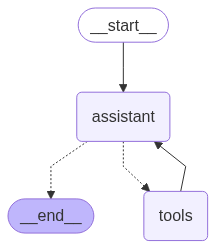

In [5]:
memory = MemorySaver()
builder = StateGraph(MessagesState)

# Nodes Logic
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

# Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# Compile
react_graph_with_memory = builder.compile(checkpointer=memory)
display(Image(react_graph_with_memory.get_graph().draw_mermaid_png()))

## Testing the Graph

In [6]:
config = {"configurable": {"thread_id": "1"}}

In [7]:
%%time
messages = [HumanMessage(content="Add 13 and 7. Multiply the output by 4. Divide the output by 5. Last, substact the output with 6.")]
messages = react_graph_with_memory.invoke({"messages": messages}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 13 and 7. Multiply the output by 4. Divide the output by 5. Last, substact the output with 6.
================================== Ai Message ==================================
Tool Calls:
  add (call_lOcVBcaaLvrD8RJMUX8UFsIH)
 Call ID: call_lOcVBcaaLvrD8RJMUX8UFsIH
  Args:
    a: 13
    b: 7
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8ymhhHIGdqVp21IfZT5z0Xbo)
 Call ID: call_8ymhhHIGdqVp21IfZT5z0Xbo
  Args:
    a: 20
    b: 4
================================= Tool Message =================================
Name: multiply

80
================================== Ai Message ==================================
Tool Calls:
  divide (call_NGLy7IMyJM8rtGREiMLKRu3E)
 Call ID: call_NGLy7IMyJM8rtGREiMLKRu3E
  Args:
    a: 80
    b: 5
=======================

In [8]:
%%time
messages = [HumanMessage(content="Multiply it with 6 and then add with 9.")]
messages = react_graph_with_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 13 and 7. Multiply the output by 4. Divide the output by 5. Last, substact the output with 6.
================================== Ai Message ==================================
Tool Calls:
  add (call_lOcVBcaaLvrD8RJMUX8UFsIH)
 Call ID: call_lOcVBcaaLvrD8RJMUX8UFsIH
  Args:
    a: 13
    b: 7
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8ymhhHIGdqVp21IfZT5z0Xbo)
 Call ID: call_8ymhhHIGdqVp21IfZT5z0Xbo
  Args:
    a: 20
    b: 4
================================= Tool Message =================================
Name: multiply

80
================================== Ai Message ==================================
Tool Calls:
  divide (call_NGLy7IMyJM8rtGREiMLKRu3E)
 Call ID: call_NGLy7IMyJM8rtGREiMLKRu3E
  Args:
    a: 80
    b: 5
=======================

# UI

In [10]:
config = {"configurable": {"thread_id": "gradio_chat"}}

def chat(message, history, graph=react_graph_with_memory):
    messages = [HumanMessage(content=message)]
    messages = graph.invoke({"messages": messages}, config)
    ai_messages = [m for m in messages["messages"] if isinstance(m, AIMessage)]
    return ai_messages[-1].content if ai_messages else "No AI response."

view = gr.ChatInterface(
    chat,
    title="LangGraph Arithmetic Assistant with Memory",
    type="messages"
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [9]:
# Checking the graph history
states = react_graph_with_memory.get_state_history(config)

for state in states:
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Add 13 and 7. Multiply the output by 4. Divide the output by 5. Last, substact the output with 6.', additional_kwargs={}, response_metadata={}, id='2e024cdb-d8a0-41d6-ba09-ca02adf56e42'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lOcVBcaaLvrD8RJMUX8UFsIH', 'function': {'arguments': '{"a":13,"b":7}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 186, 'total_tokens': 203, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BhRlDepbzGxmOuR1UHUVhYkObfiYx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a806d86a-d4cd-487d-bd08-94cf7e8fa3b7-